In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from boruta import BorutaPy
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
# from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score
from catboost import CatBoostRegressor
import pickle
from colorama import Fore, Back, Style
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.linear_model import Ridge
seed = 42

from sklearn import svm
from imblearn.over_sampling import SMOTE

Matplotlib created a temporary cache directory at /tmp/matplotlib-3e4yro6s because the default path (/home/youngtaek/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
def bootstrap_auc(y_true, y_scores, n_bootstraps=1000, rng_seed=42):

    # Convert Series to numpy arrays
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()

    if isinstance(y_scores, pd.Series):
        y_scores = y_scores.to_numpy()


    n_samples = len(y_true)
    rng = np.random.default_rng(rng_seed)
    bootstrapped_aucs = []
    cut_offs = []
    for _ in range(n_bootstraps):
        try:
            # 샘플링
            indices = rng.choice(range(n_samples), size=n_samples, replace=True)
            
            # ROC AUC 계산
            auc = roc_auc_score(y_true[indices], y_scores[indices])
            
            # ROC Curve 계산
            fpr, tpr, thresholds = roc_curve(y_true[indices], y_scores[indices])

            # Youden's J statistic 계산
            J = tpr - fpr
            optimal_idx = np.argmax(J)
            optimal_threshold = thresholds[optimal_idx]
            
            # 결과 저장
            cut_offs.append(optimal_threshold)
            bootstrapped_aucs.append(auc)
        except ValueError as e:
            # 예외 발생 시 메시지 출력 후 건너뛰기
            print(f"Skipped bootstrap iteration due to error: {e}")


    cut_offs = np.array(cut_offs)
    mean_cutoff = np.mean(cut_offs)

    sorted_aucs = np.array(sorted(np.unique(bootstrapped_aucs)))
    mean_auc = np.mean(sorted_aucs)

    lower_bound = np.percentile(sorted_aucs, 2.5)
    upper_bound = np.percentile(sorted_aucs, 97.5)
    return lower_bound, upper_bound, mean_auc, mean_cutoff


In [ ]:
def plot_AUC_graph(y_true, y_pred, filename):
    train_auc = roc_auc_score(y_true, y_pred)

    # Compute the area under the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Compute 95% CI for AUROC using bootstrapping
    lower_bound, upper_bound, _, _ = bootstrap_auc(y_true, y_pred)

    # Compute ROC curve and AUROC
    # Plot ROC curve
    plt.figure(figsize=(6, 6))

    # Diagonal in red
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    # Actual ROC curve without a label
    plt.plot(fpr, tpr, color='dodgerblue', linestyle='-', linewidth=2.5)

    # Add a 'fake' empty line just for the legend entry
    plt.plot([], [], alpha=0.0, label=f'AUC: {train_auc:.2f}\n[95% CI: {lower_bound:.2f}-{upper_bound:.2f}]')  # alpha=0.0 makes it invisible

    # Display the legend without the box or any handle (line indicators)
    plt.legend(handlelength=0, handletextpad=0, frameon=False, fontsize='large')

    # Axis labels and title
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title('RadScore_adjusted', fontsize=16)

    # Display legend
    plt.legend(loc='lower right', fontsize=12)

    # Adjust plot aesthetics
    plt.grid(alpha=0.2)
    plt.tight_layout()

    # plt.savefig('./figures/{}.png'.format(filename), dpi=300, bbox_inches='tight')


In [ ]:
df = pd.read_excel('merged_DB_at_major_revision_v4.xlsx', engine='openpyxl')
print (df.shape)

(2324, 934)


In [ ]:
# Softmax function
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()

In [ ]:
# Compute the cube root and add a new column
df['seg_PlaqueVolume_cbrt'] = df['seg_PlaqueVolume'] ** (1/3)

In [ ]:
# Perform group-wise softmax calculation
df['softmax_seg_PlaqueVolume'] = df.groupby('NewID')['seg_PlaqueVolume'].transform(lambda x: softmax(x))

In [ ]:
df['softmax_seg_PlaqueVolume_cbrt'] = df.groupby('NewID')['seg_PlaqueVolume_cbrt'].transform(lambda x: softmax(x))


In [ ]:
train_df = df[df["Site_ID"].isin([3,9])]
test_df = df[~df["Site_ID"].isin([3,9])]

print(f"Train shape: {train_df.shape}, Unique NewID count: {train_df['NewID'].nunique()}")
print(f"Test shape: {test_df.shape}, Unique NewID count: {test_df['NewID'].nunique()}")

Train shape: (1898, 934), Unique NewID count: 443
Test shape: (426, 934), Unique NewID count: 120


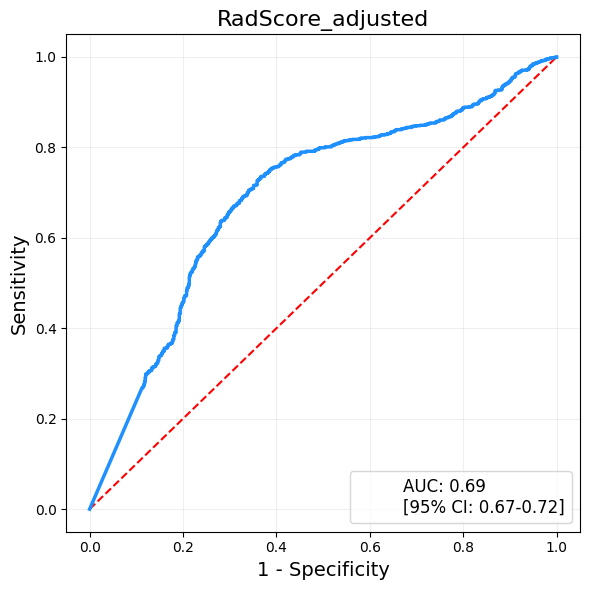

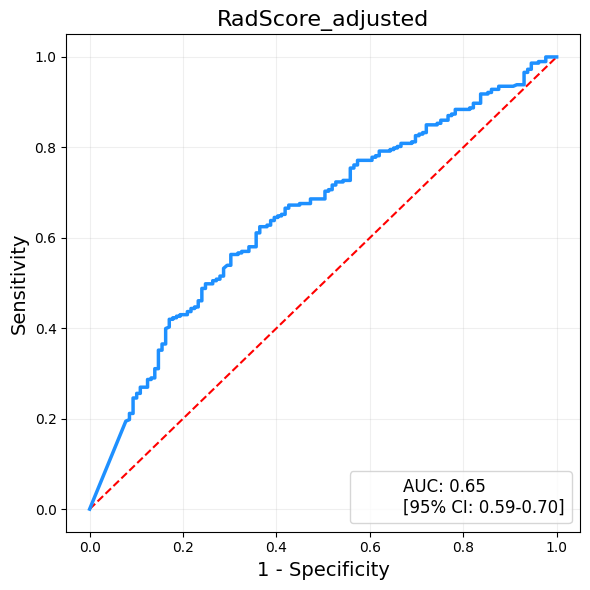

In [ ]:
# load model
clf = load('.././MajorRevision/LGBMClassifier_segment_prediction_StatinResponder_site39_exp03.joblib')

# feature_selection
feature_importances = pd.read_csv('.././MajorRevision/feature_selection_StatinResponder_site39.csv')
features = feature_importances['Feature'].values.tolist()


inputs = train_df.filter(regex='pre_original|pre_wavelet')
target = train_df['StatinResponder']
data = pd.concat([inputs, target], axis=1)
# train_df.dropna(subset=data.columns, inplace=True)
train_df = train_df.dropna(subset=data.columns)


inputs = test_df.filter(regex='pre_original|pre_wavelet')
target = test_df['StatinResponder']
data = pd.concat([inputs, target], axis=1)
# test_df.dropna(subset=data.columns, inplace=True)
test_df = test_df.dropna(subset=data.columns)

# train, test data
y_train = train_df['StatinResponder']
X_train = train_df[features]

y_test = test_df['StatinResponder']
X_test = test_df[features]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# prediction
y_train_pred = clf.predict_proba(X_train_resampled)[:,1]
plot_AUC_graph(y_true=y_train_resampled, y_pred=y_train_pred, filename="train_new_model")

y_test_pred = clf.predict_proba(X_test)[:,1]
plot_AUC_graph(y_true=y_test, y_pred=y_test_pred, filename="test_new_model")

In [ ]:
features = feature_importances['Feature'].values.tolist()

y_train = train_df['StatinResponder']
X_train = train_df[features]

y_test = test_df['StatinResponder']
X_test = test_df[features]

y_pred_proba = clf.predict_proba(X_train)[:, 1]
train_df.loc[:, 'prob'] = y_pred_proba  # <-- .loc 사용

y_pred_proba = clf.predict_proba(X_test)[:, 1]
test_df.loc[:, 'prob'] = y_pred_proba  # <-- .loc 사용


In [ ]:
# probabilty weighted by softmax
train_df['softmax_cbrt_weighted_prob'] = train_df['softmax_seg_PlaqueVolume_cbrt'] * train_df['prob']
test_df['softmax_cbrt_weighted_prob'] = test_df['softmax_seg_PlaqueVolume_cbrt'] * test_df['prob']

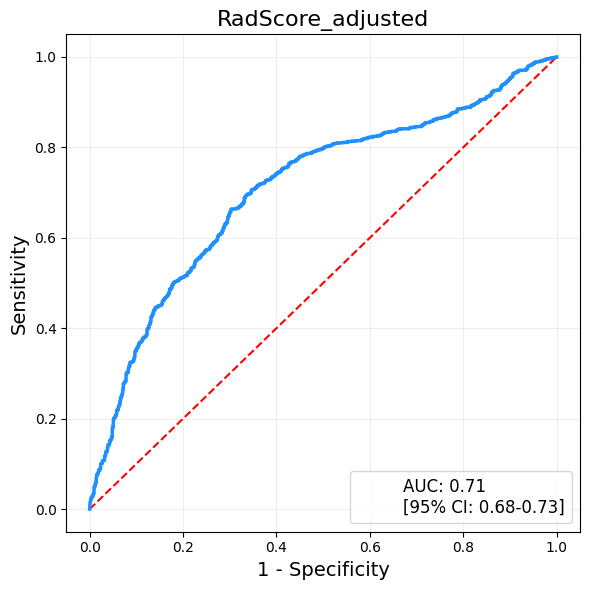

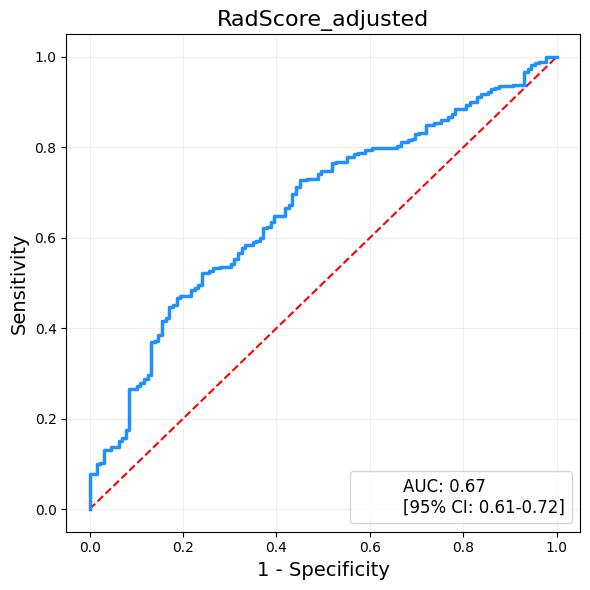

In [ ]:
plot_AUC_graph(y_true=train_df['StatinResponder'], y_pred=train_df['softmax_cbrt_weighted_prob'], filename="train_new_model_test")
plot_AUC_graph(y_true=test_df['StatinResponder'], y_pred=test_df['softmax_cbrt_weighted_prob'], filename="test_new_model_test")

In [ ]:
# ROC plot
fpr, tpr, thresholds = roc_curve(train_df['StatinResponder'], train_df['softmax_cbrt_weighted_prob'])

# AUC
auc = roc_auc_score(train_df['StatinResponder'], train_df['softmax_cbrt_weighted_prob'])

# Youden's index
J = tpr - fpr
ix = np.argmax(J)

optimal_threshold = thresholds[ix]

In [ ]:
train_df['rdis'] = train_df['softmax_cbrt_weighted_prob'] - optimal_threshold
test_df['rdis'] = test_df['softmax_cbrt_weighted_prob'] - optimal_threshold

In [ ]:
def get_patient_score(df, optimal_threshold):
    results = []

    grouped = df.groupby('NewID')

    for name, group in grouped:
        RIL_plus = group[group['rdis'] > 0]['rdis'].tolist()
        RIL_minus = group[group['rdis'] <= 0]['rdis'].tolist()

        summated_relative_distance_p = abs(sum(RIL_plus))
        summated_relative_distance_n = abs(sum(RIL_minus))

        if len(RIL_plus) > 0 and summated_relative_distance_p >= summated_relative_distance_n:
            average = (sum(RIL_plus) / len(RIL_plus)) + optimal_threshold
        elif len(RIL_minus) > 0:
            average = (sum(RIL_minus) / len(RIL_minus)) + optimal_threshold
        else:   
            # Handle cases where both RIL_plus and RIL_minus are empty or zero  
            # Here, only optimal_threshold is used, but other processing can be applied if needed.
            average = optimal_threshold
        
        results.append({
            "NewID": name,
            "avg_prob": average,
        })

    # Convert the list of dictionaries to a DataFrame
    patient_level_df = pd.DataFrame(results)

    return patient_level_df

In [ ]:
patient_level_train_df = get_patient_score(train_df, optimal_threshold)

temp = train_df.merge(patient_level_train_df, on='NewID', how='inner')
patient_level_train_df = temp.drop_duplicates(subset='NewID', keep='first')


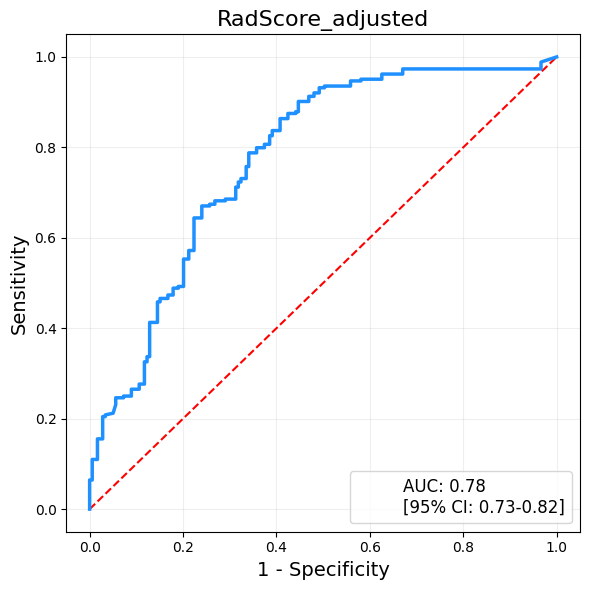

In [ ]:
plot_AUC_graph(y_true=patient_level_train_df["StatinResponder"], y_pred=patient_level_train_df["avg_prob"], filename="test_new_model")


In [ ]:
patient_level_test_df = get_patient_score(test_df, optimal_threshold)

temp = test_df.merge(patient_level_test_df, on='NewID', how='inner')
patient_level_test_df = temp.drop_duplicates(subset='NewID', keep='first')

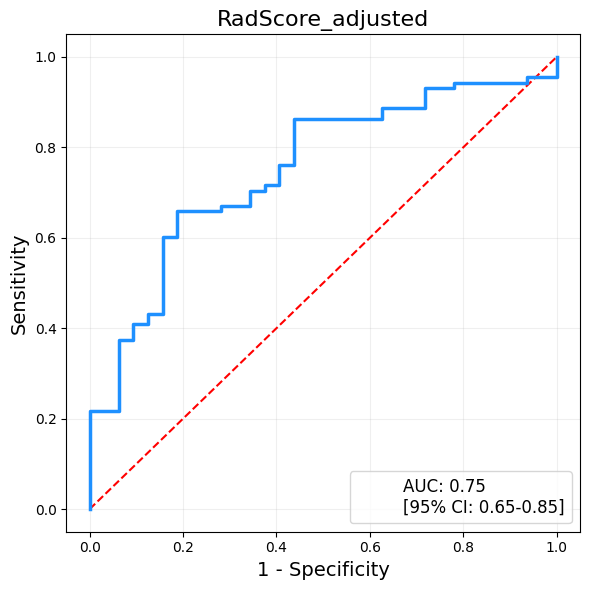

In [ ]:
plot_AUC_graph(y_true=patient_level_test_df["StatinResponder"], y_pred=patient_level_test_df["avg_prob"], filename="test_new_model")